In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os,sys,progressbar
import numpy as np
import pandas as pd
import astropy.stats as stat

import matplotlib
from   matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

rc('text', usetex=True)
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

sys.path.insert(1, '/home/amarins/ComponentSeparation/gmca/scripts')
import Extension4BINGO as cs
import statcosmo as statc

import pymaster as nmt
import healpy as hp
import astropy.io.fits as fits

In [2]:
#####################################
#paths
#####################################
pathcls       = "/home/amarins/ComponentSeparation/gmca/outputs/GMCAn3nr100" 
dir_hi        = "21cm"        #Directory name of the cls of the 21cm reconstruction maps
dir_fg        = "foregrounds" #Directory name of the cls of the foregrounds reconstruction maps
dir_prior     = "prior"       #Directory name of the cls of the prior maps, that can be (21cm + noise) masked
dir_noise     = "noise"       #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_pure      = "pure"        #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projnoise = "projnoise"   #Directory name of the cls of the noise maps, that can be (WhiteNoise or/and 1/f) masked
dir_projpure  = "projpure"    #Directory name of the cls of the (only) 21cm maps, masked or not.
dir_projprior = "projprior"   #

name_mask = "Mask_Bin.fits"#"Mask_tot256.fits" #put this file in the same directory of the other maps
#Noise debias model
model     = "filipe"
#Bootstrap parameters
n_samples = 1e4

In [3]:
Cls        = cs.loadcls(pathcls,dirs=[dir_hi,dir_fg,dir_prior,dir_noise,dir_pure])  
#Cls_ndb    = statc.output_debias(Cls=Cls, model=model, output="Cls_debias",dir_hi = dir_hi, dir_prior=dir_prior, dir_noise = dir_noise)
#Cls_binned = statc.data_binned(Cls_ndb) #constroi os cls por bin, com diferentes realizacoes
#std_jack   = statc.jacknnife_stat(Cls_binned, stat_func=np.std) #results per bin

In [4]:
dir_mask      = "/media/new-drive/amarins/maps/mask"
pathmask  = os.path.join(dir_mask,name_mask)
with fits.open(pathmask) as h:
    mask = h[0].data

dir_observed  = "/media/new-drive/CS_Cubes/White_Noise/input_wn"
pathmap = os.path.join(dir_observed,'Cube_Input_WN_L10_M.fits')
with fits.open(pathmap) as h:
    maps = h[0].data
    
dir_noise     = "/media/new-drive/CS_Cubes/Only_White_Noise_Masked"
pathnoise = os.path.join(dir_noise,'bingo_WN_256_mK_CubeA_10Masked.fits')
with fits.open(pathnoise) as h:
    maps_WN = h[0].data
    
    
dir_pure      = "/media/new-drive/CS_Cubes/No_Noise/prior_nn"
pathpure = os.path.join(dir_pure,'Cube_Prior_L10M.fits')
with fits.open(pathpure) as h:
    maps_HI = h[0].data

In [5]:
bin_   = 10
maps10 = maps[bin_]
mapsWN = maps_WN[bin_]
mapsHI = maps_HI[bin_]
mask0  = np.zeros_like(mask)
mask1  = np.ones_like(mask)
nside = hp.npix2nside(maps10.size)

In [7]:
nbinned = 2
#f_0_hi     = nmt.NmtField(mask = mask1, maps = [mapsHI])
f_0_obs    = nmt.NmtField(mask = mask, maps = [maps10], masked_on_input=True)
cl_coupled = nmt.compute_coupled_cell(f_0_obs,f_0_obs)

In [8]:
cl_obs     =  hp.anafast(maps10)

<Figure size 576x432 with 0 Axes>

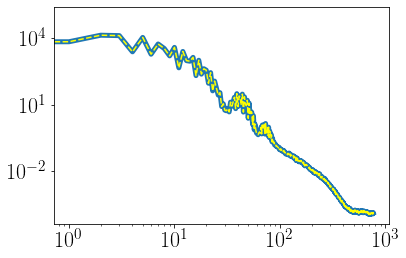

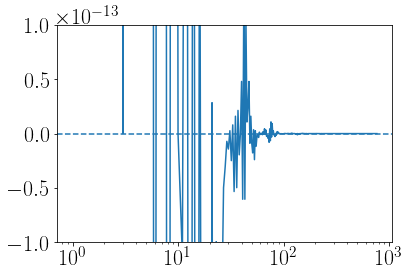

In [9]:
plt.figure(figsize=(8,6))
plt.subplots()
plt.loglog(cl_coupled[0], linestyle="solid", linewidth=5)
plt.loglog(cl_obs,        color='yellow', linestyle="dashed");
plt.subplots()
plt.semilogx(cl_coupled[0]-cl_obs)
plt.axhline(y=0, linestyle="dashed")
plt.ylim(-1e-13,1e-13);

In [10]:
def get_sample_field(mask=None, cl_tt=None, Nside=None):
    mp_t = hp.synfast(cls=cl_tt, nside=nside, verbose=False)
    return nmt.NmtField(mask, [mp_t])

def compute_master(f_a, f_b, wsp):
    cl_coupled   = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [20]:
nbinned = 4
b       = nmt.NmtBin.from_nside_linear(nside, nbinned)
w00     = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f_0_obs, f_0_obs, b)
cl_00   = compute_master(f_0_obs, f_0_obs, w00)

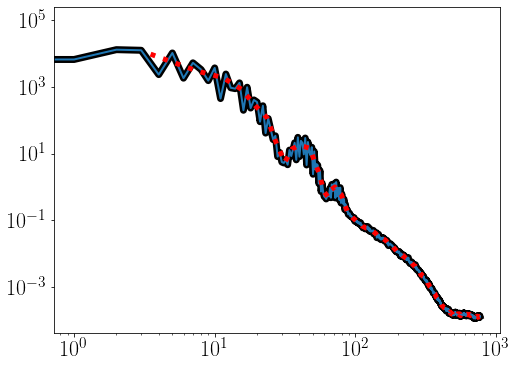

In [21]:
plt.figure(figsize=(8,6))
plt.loglog(cl_obs, linestyle="solid", linewidth=7, color="black")
plt.loglog(cl_coupled[0], linestyle="solid", linewidth=2)
plt.loglog(b.get_effective_ells(), cl_00[0], color='red', linestyle="dotted",linewidth=5,label="");

In [16]:
f_0_obs = nmt.NmtField(mask = mask1, maps = [maps10])
cl_obs  =  hp.anafast(maps10)
b       = nmt.NmtBin.from_nside_linear(nside, 10)
w00     = nmt.NmtWorkspace()
w00.compute_coupling_matrix(f_0_obs, f_0_obs, b)
cl_00 = compute_master(f_0_obs, f_0_obs, w00)
n_ell = len(cl_00[0])
cw    = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f_0_obs, f_0_obs, f_0_obs, f_0_obs)
covar_00_00 = nmt.gaussian_covariance(cw,
                                      0, 0, 0, 0,  # Spins of the 4 fields
                                      [cl_obs],  # TT
                                      [cl_obs],  # TT
                                      [cl_obs],  # TT
                                      [cl_obs],  # TT
                                      w00, wb=w00).reshape([n_ell, 1,
                                                            n_ell, 1])
covar_TT_TT = covar_00_00[:, 0, :, 0]

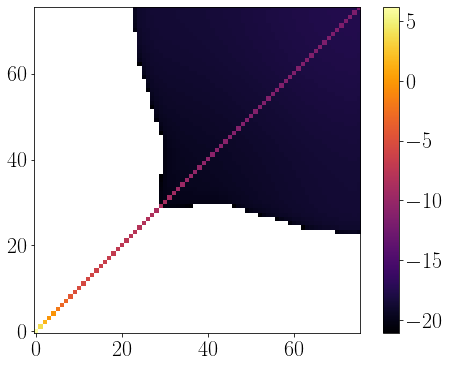

In [19]:
plt.figure(figsize=(8,6))
plt.imshow(np.log10(covar_TT_TT), origin='lower', interpolation='nearest',cmap='inferno')
plt.colorbar();

In [144]:
# Let's now compute the sample covariance
# (we'll only do this for spin-0 for simplicity
print("Sample covariance")
nsamp = 100
covar_sample = np.zeros([n_ell, n_ell])
mean_sample = np.zeros(n_ell)
for i in np.arange(nsamp):
    f  = get_sample_field(mask=mask1, cl_tt=cl_obs, Nside=nside)
    cl = compute_master(f, f, w00)[0]
    covar_sample += cl[None, :]*cl[:, None]
    mean_sample += cl
mean_sample /= nsamp
covar_sample = covar_sample / nsamp
covar_sample -= mean_sample[None, :] * mean_sample[:, None]

Sample covariance
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


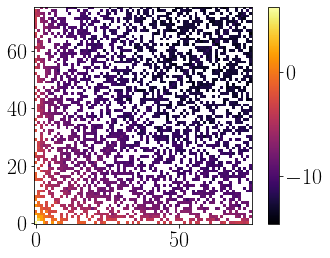

In [148]:
plt.imshow(np.log10(covar_sample), origin='lower', interpolation='nearest',cmap='inferno')
plt.colorbar();

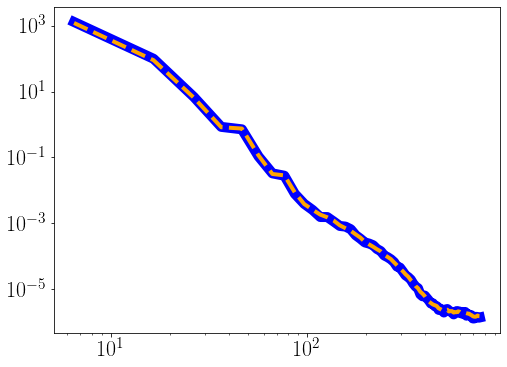

In [149]:
plt.figure(figsize=(8,6))
plt.loglog(b.get_effective_ells(),np.sqrt(np.diag(covar_sample)), color="blue", linestyle="solid", linewidth=10)
plt.loglog(b.get_effective_ells(),np.sqrt(np.diag(covar_TT_TT)),  color="orange", linestyle="dashed", linewidth=4)

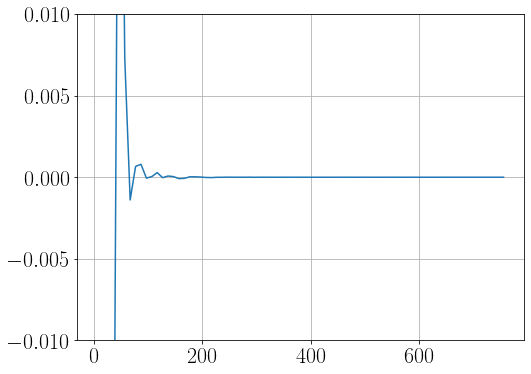

In [150]:
plt.figure(figsize=(8,6))
plt.plot(b.get_effective_ells(),-np.sqrt(np.diag(covar_sample))+np.sqrt(np.diag(covar_TT_TT)))
plt.ylim(-0.01,0.01)
plt.grid()